### libs and defs


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
import skrf.plotting as skplt
import plotly.graph_objects as go

# Load the S-parameter file
bjt = rf.Network('Sparam-partI.s2p', )
s = bjt.s.copy()
s[:,0,1], s[:,1,0] = s[:,1,0].copy(), s[:,0,1].copy()
bjt.s = s

# Filter for 4 GHz
freq_idx = rf.util.find_nearest_index(bjt.f, 4.e+9)
freq_point = bjt[freq_idx]
print(f"Frequency point at 4 GHz:\n{freq_point}")

# Define a function to calculate the square of the absolute value
def sqabs(x): return np.square(np.absolute(x))

def calc_circle(c, r):
    theta = np.linspace(0, 2*np.pi, 1000)
    return c + r*np.exp(1.0j*theta)

def calc_point_in_smith_circle(z):
    c = (z - 1) / (z + 1)
    return  calc_circle(c, 0)

def prep_fig_smith_chart():
    # prepare figure
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    background = plt.imread('Smith_chart_gen.png')
    ax.imshow(background, extent=[-1.182, 1.188, -1.182, 1.182])
    # impedance smith chart
    skplt.smith(ax = ax, draw_labels = True, chart_type = 'z')

Frequency point at 4 GHz:
2-Port Network: 'Sparam-partI_subset',  4003110721.81212-4003110721.81212 Hz, 1 pts, z0=[50.+0.j 50.+0.j]


In [2]:
# show  the information of the network
bjt

2-Port Network: 'Sparam-partI',  1000000000.0-10000000000.0 Hz, 1002 pts, z0=[50.+0.j 50.+0.j]

In [3]:
# Plot the S-parameters
# bjt.s

In [4]:
# show the frequency points
# bjt.frequency.f_scaled

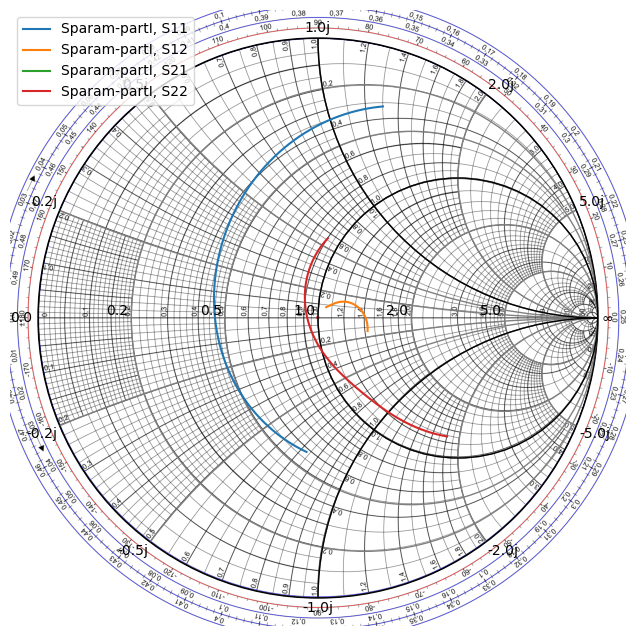

In [5]:
prep_fig_smith_chart()

# impedance smith chart
bjt.plot_s_smith()

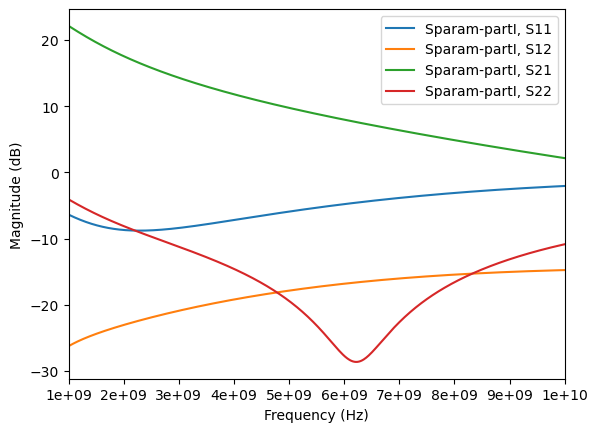

In [6]:
# plot the S-parameters in dB
bjt.plot_s_db()

In [7]:
# plot the S-parameters in dB for the frequency range 3-5 GHz
# bjt['3-5ghz'].plot_s_db()

In [8]:
# plot phase of S-parameters in degrees
# bjt.plot_s_deg()

### Bias


In [9]:
from sympy import solve, symbols, pprint
r1, r2, r3, r4, b, vbe, vce, vcc, ib, ic, ie = symbols(
    'R_1 R_2 R_3 R_4 beta V_{BE} V_{CE} V_{CC} I_b I_C I_E')


r2 = 1e3
r4 = 100
vcc = 10
b = 72.534
ic = 9e-3
vbe = 1
vce = 5

ib = ic/b
ie = (b+1)*ib
eq1 = vcc - r3*ic-r4*ie-vce
vth = vcc*(r2/(r1+r2))
rth = (r1*r2)/(r1+r2)
eq2 = -vth + ib*rth+vbe+ie*r4

s = solve([eq1, eq2], [r1, r3])
pprint(s)

{R₁: 3971.3433878574, R₃: 454.17689175651}


### Stability


/var/folders/q2/6c9pq0ld17dcrdxrph5h7gd00000gn/T/ipykernel_75766/3238084178.py:13: RuntimeWarning: invalid value encountered in sqrt
  MAG = np.abs(bjt.s21.s/bjt.s12.s) * (k-np.sqrt(np.square(k)-1))


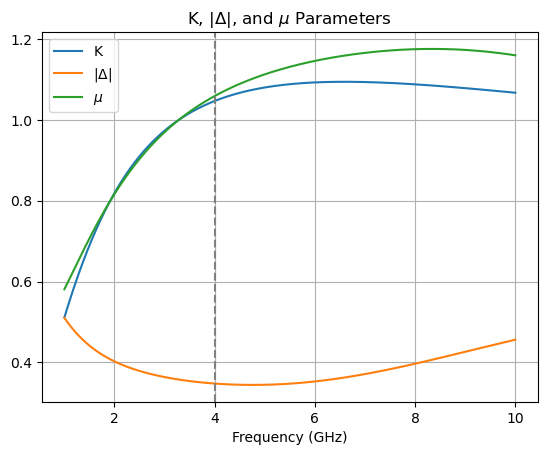

In [10]:
# delta is the determinant of the S-parameter matrix
delta = bjt.s11.s * bjt.s22.s - bjt.s12.s * bjt.s21.s

# k calculation
k = (1 - sqabs(bjt.s11.s) - sqabs(bjt.s22.s) + sqabs(delta)) / \
    (2 * np.abs(bjt.s12.s * bjt.s21.s))

# mu calculation
mu = (1 - sqabs(bjt.s11.s)) / (np.abs(bjt.s22.s -
                                      (delta*np.conj(bjt.s11.s)))+np.abs(bjt.s21.s*bjt.s12.s))

# Maximum available gain (MAG) calculation
MAG = np.abs(bjt.s21.s/bjt.s12.s) * (k-np.sqrt(np.square(k)-1))

k = np.squeeze(k)  # Remove any singleton dimensions
delta = np.squeeze(delta)  # Remove any singleton dimensions
mu = np.squeeze(mu)  # Remove any singleton dimensions
MAG = np.squeeze(MAG)  # Remove any singleton dimensions

# Plotting k values
plt.figure()
plt.plot(bjt.f/1e9, k)
plt.plot(bjt.f/1e9, np.abs(delta))
plt.plot(bjt.f/1e9, mu)
# add line in 4 Ghz
plt.axvline(x=4, color='gray', linestyle='--')
plt.title('K, |$\\Delta$|, and $\\mu$ Parameters')
plt.xlabel('Frequency (GHz)')

plt.grid()
plt.legend(['K', '|$\\Delta$|', '$\\mu$'])
plt.show()

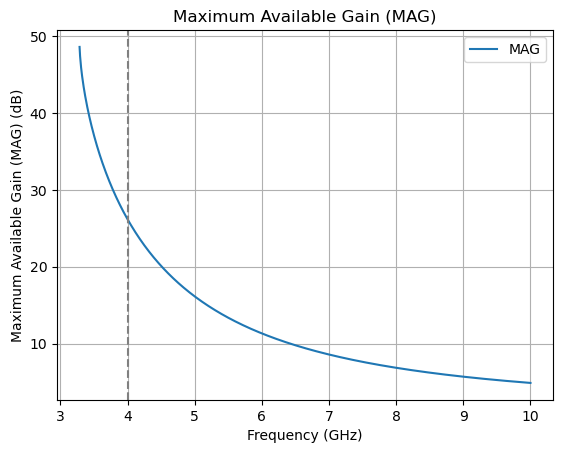

MAG at 4 GHz: 26.12638415165541


In [11]:
# Plotting Maximum Available Gain (MAG)
plt.figure()
plt.plot(bjt.f/1e9, MAG)
# add line in 4 Ghz
plt.axvline(x=4, color='gray', linestyle='--')
plt.title('Maximum Available Gain (MAG)')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Maximum Available Gain (MAG) (dB)')
plt.grid()
plt.legend(['MAG'])
plt.show()

# Print MAG at 4 Ghz
val = MAG[freq_idx]
print('MAG at 4 GHz:', val)

In [12]:
# Calculate stability circle
rl = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s22.s) - sqabs(delta)))
cl = np.conj(bjt.s22.s - delta*np.conj(bjt.s11.s)) / \
    (sqabs(bjt.s22.s) - sqabs(delta))

rs = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s11.s) - sqabs(delta)))
cs = np.conj(bjt.s11.s - delta*np.conj(bjt.s22.s)) / \
    (sqabs(bjt.s11.s) - sqabs(delta))

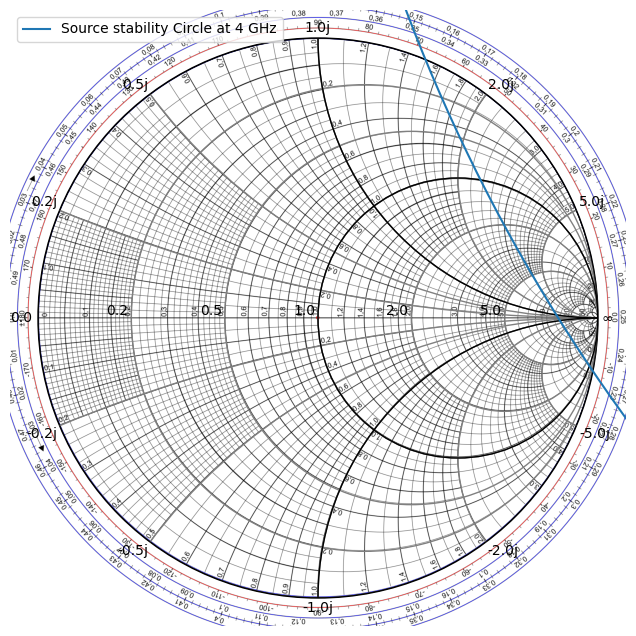

In [13]:
prep_fig_smith_chart()

# Plot all the stability circles for source
# for i, f in enumerate(bjt.f):
#     # decimate it a little
#     if i % 100 != 0:
#         continue
#     n = rf.Network(name=str(f/1.e+9), s=calc_circle(cs[i][0, 0], rs[i][0, 0]))
#     n.plot_s_smith()

# Plot the stability circles at 4 GHz of source
circle_points = calc_circle(cs[freq_idx][0,0], rs[freq_idx][0,0])
myfreq = rf.Network(s=circle_points)
myfreq.plot_s_smith(label='Source stability Circle at 4 GHz')


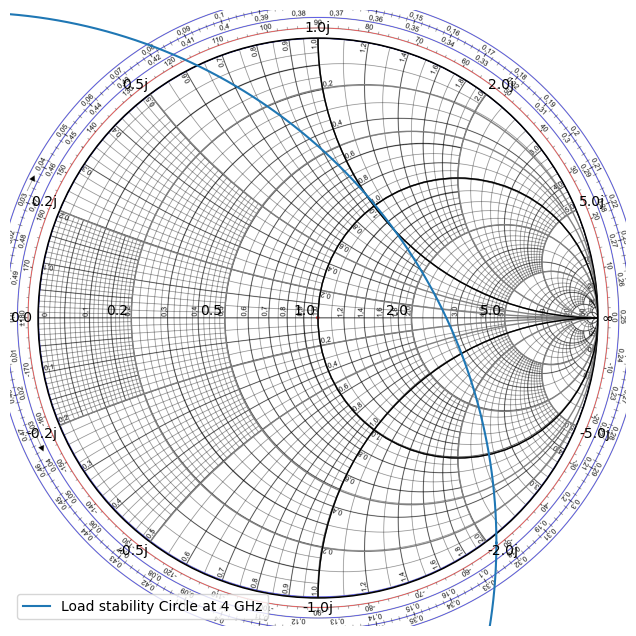

In [14]:
# Plot all the stability circles for load
# for i, f in enumerate(bjt.f):
#     # decimate it a little
#     if i % 100 != 0:
#         continue
#     t = rf.Network(name=str(f/1.e+9), s=calc_circle(cl[i][0, 0], rl[i][0, 0]))
#     t.plot_s_smith()

prep_fig_smith_chart()

# Plot the stability circles at 4 GHz of load
circle_points = calc_circle(cl[freq_idx,0,0], rl[freq_idx,0,0])
myfreq = rf.Network(s=circle_points)
myfreq.plot_s_smith(label='Load stability Circle at 4 GHz')

### Calc $\rho_L$ and $\rho_S$ and $\Z_L$ and $\Z_S$


In [15]:
# Calcular B1, B2, C1 e C2
print("Frequency (GHz):", bjt.f[freq_idx] / 1e9)
delta4GHz = delta[freq_idx]
print('delta4GHz:', delta4GHz)

# S11 and S22 for 4 GHz
s11 = freq_point.s11.s[0, 0]
s22 = freq_point.s22.s[0, 0]
s12 = freq_point.s12.s[0, 0]
s21 = freq_point.s21.s[0, 0]
print('S11:', s11)
print('S22:', s22)
print('S12:', s12)
print('|s11|: ', np.abs(s11))
print('|s22|: ', np.abs(s22))
print('|s12|: ', np.abs(s12))

B1 = 1 + sqabs(s11) - sqabs(s22) - sqabs(delta4GHz)
print('B1:', B1)
B2 = 1 + sqabs(s22) - sqabs(s11) - sqabs(delta4GHz)
print('B2:', B2)
C1 = s11 - (delta4GHz * np.conj(s22))
print('C1:', C1)
C2 = s22 - (delta4GHz * np.conj(s11))
print('C2:', C2)

# Calcular ros (ρs) e rol (ρL)
ros = (B1 - np.sqrt(np.square(B1) - 4 * sqabs(C1))) / (2 * C1)
rol = (B2 - np.sqrt(np.square(B2) - 4 * sqabs(C2))) / (2 * C2)
print("ros (ρs):", ros)
print("rol (ρL):", rol)
zs = (1 + ros) / (1 - ros)
zl = (1 + rol) / (1 - rol)
print("zs:", zs)
print("zl:", zl)

Frequency (GHz): 4.00311072181212
delta4GHz: (-0.03435616234300311-0.34612226701384374j)
S11: [-0.33990673+0.27537675j]
S22: [0.06042986-0.17647029j]
S12: [0.09296393+0.05839295j]
|s11|:  [0.43745736]
|s22|:  [0.18653024]
|s12|:  [0.10978173]
B1: [1.03559444]
B2: [0.72244362]
C1: [-0.39891088+0.30235572j]
C2: [0.144066-0.30358047j]
ros (ρs): [-0.61339711-0.4649262j]
rol (ρL): [0.29177619+0.6148401j]
zs: [0.14457529-0.32982769j]
zl: [0.6103145+1.39798452j]


In [16]:
zs = np.squeeze(zs)  # Remove any singleton dimensions
zl = np.squeeze(zl)  # Remove any singleton dimensions

fig = go.Figure()
fig.add_trace(go.Scattersmith(
    real=[float(np.real(zs))],
    imag=[float(np.imag(zs))],
    mode="markers",
    marker=dict(color="blue", size=8),
    name=f"Zs* = {zs:.2f}"
))
fig.add_trace(go.Scattersmith(
    real=[float(np.real(zl))],
    imag=[float(np.imag(zl))],
    mode="markers",
    marker=dict(color="red", size=8),
    name=f"Zl* = {zl:.2f}"
))
fig.update_layout(
    showlegend=True,
    width=600,
    height=600,
    title="Source and load conjugate impedances at 4 GHz",
    title_x=0.5,
    legend=dict(
        x=1.05,
        y=1.08,
        xanchor='right',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.7)'
    )
)
fig.show()

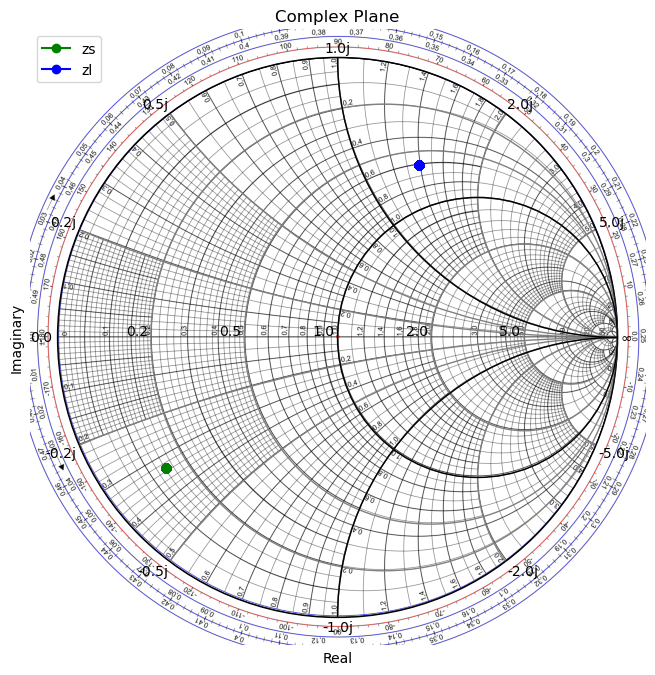

In [17]:
prep_fig_smith_chart()

zspoint = calc_point_in_smith_circle(zs)
zlpoint = calc_point_in_smith_circle(zl)
skplt.plot_smith(s=(zspoint), color = 'green', draw_labels=True, marker = 'o', label='zs')
skplt.plot_smith(s=(zlpoint), color = 'blue', draw_labels=True, marker ='o', label='zl')




In [18]:
# k calculation for 4 GHz
k4Ghz = k[freq_idx]
print("k (4 GHz):", k4Ghz)
#maximum transducer gain
GTUmax = (1)/(1-sqabs(s11))*sqabs(21)*(1)/(1-sqabs(s22))
print("Maximum Transducer Gain (GTUmax):", GTUmax)

#maximum transducer power gain
GTmax = (np.abs(s21))/(np.abs(s12))*(k4Ghz - np.sqrt(np.square(k4Ghz) - 1))
print("Maximum Transducer Power Gain (GTmax):", GTmax)

#maximum stable gain
Gmsg = (np.abs(s21))/(np.abs(s12))
print("Maximum Stable Gain (Gmsg):", Gmsg)

k (4 GHz): 1.0469904956488176
Maximum Transducer Gain (GTUmax): [565.02536719]
Maximum Transducer Power Gain (GTmax): [26.12638415]
Maximum Stable Gain (Gmsg): [35.45700864]


### Calc matching source and load circuit with Lumped elements in L


In [19]:

def calc_lumped_matching_circuits(f, z0, rl, xl):
    zl = rl + 1j*xl
    zl = np.conj(zl)
    rl = np.real(zl)
    xl = np.imag(zl)
    if rl > 1:
        b1 = (xl + (np.sqrt(rl/z0)*np.sqrt(np.square(rl) +
              np.square(xl)-z0*rl)))/(np.square(rl)+np.square(xl))
        b2 = (xl - (np.sqrt(rl/z0)*np.sqrt(np.square(rl) +
              np.square(xl)-z0*rl)))/(np.square(rl)+np.square(xl))

        xa = 1/b1 + (xl*z0/rl) - (z0/(b1*rl))
        x1 = xa
        x2 = - xa

        if b1 > 0:
            bmais = b1
            bmenos = b2
        else:
            bmais = b2
            bmenos = b1
        if x1 > 0:
            xmais = x1
            xmenos = x2
        else:
            xmais = x2
            xmenos = x1
        print("------------------------------------")
        print("Z0 - Xserie + Bparalelo - Z")
        print("B+ = ", bmais)
        print("X+ = ", xmais)
        print("B- = ", bmenos)
        print("X- = ", xmenos)
        print("------------------------------------")
        z0 = 50
        L_serie = xmais*z0/(2*np.pi*f)
        C_paralelo = bmais/(2*np.pi*f*z0)
        L_paralelo = -z0/(bmenos*2*np.pi*f)
        C_serie = -1/(z0*xmenos*2*np.pi*f)
        print("L_serie = ", L_serie)
        print("C_paralelo = ", C_paralelo)
        print("L_paralelo = ", L_paralelo)
        print("C_serie = ", C_serie)
        print("------------------------------------")
    else:
        xa = np.sqrt(rl*(z0-rl))
        if (xl < 0):
            xmenos = -np.abs(xa - xl)
            xmais = np.abs(-xa - xl)
        else:
            xmenos = -xa - xl
            xmais = xa - xl

        ba = np.sqrt((z0-rl)/rl)/z0
        bmais = ba
        bmenos = -ba

        print("------------------------------------")
        print("Z0 - Bparalelo + Xserie - Z")
        print("X+ = ", xmais)
        print("X- = ", xmenos)
        print("B+ = ", bmais)
        print("B- = ", bmenos)
        print("------------------------------------")
        z0 = 50
        L_serie = xmais*z0/(2*np.pi*f)
        C_paralelo = bmais/(2*np.pi*f*z0)
        L_paralelo = -z0/(bmenos*2*np.pi*f)
        C_serie = -1/(z0*xmenos*2*np.pi*f)
        print("L_serie = ", L_serie)
        print("C_paralelo = ", C_paralelo)
        print("L_paralelo = ", L_paralelo)
        print("C_serie = ", C_serie)
        print("------------------------------------")
    return


f = freq_point.f[0]
rs = np.real(zs)
xs = np.imag(zs)
rl = np.real(zl)
xl = np.imag(zl)
z0 = 1

print("------------------------------------")
print("Calc source matching circuit")
calc_lumped_matching_circuits(f, z0, rs, xs)
print("------------------------------------")
print("Calc load matching circuit")
calc_lumped_matching_circuits(f, z0, rl, xl)

------------------------------------
Calc source matching circuit
------------------------------------
Z0 - Bparalelo + Xserie - Z
X+ =  0.021844423985204697
X- =  -0.6814998052731019
B+ =  2.432449641156697
B- =  -2.432449641156697
------------------------------------
L_serie =  4.342433045002919e-11
C_paralelo =  1.934177748833024e-12
L_paralelo =  8.172382322581773e-10
C_serie =  1.166774123434601e-12
------------------------------------
------------------------------------
Calc load matching circuit
------------------------------------
Z0 - Bparalelo + Xserie - Z
X+ =  0.910305617571796
X- =  -1.8856634227563571
B+ =  0.7990616411877871
B- =  -0.7990616411877871
------------------------------------
L_serie =  1.8095882031372845e-09
C_paralelo =  6.353789283779272e-13
L_paralelo =  2.487781595723932e-09
C_serie =  4.2168518958492584e-13
------------------------------------


### Calc impedance matching with lines and stubs


In [20]:
def calc_lines_stubs_circuit(z0,zl,f):
    #calc admitance
    y0 = 1/z0
    zl = zl*z0
    zl = np.conj(zl)
    rl = np.real(zl)
    xl = np.imag(zl)
    c  = 3e8
    w  = 1.5e-3
    h  = 800e-6
    er = 4
    #shunt stubs
    print("------------------------------------")
    print("Calc shunt stubs")
    print("------------------------------------")
    
    t1 = (xl + np.sqrt(rl*(np.square(z0-rl)+np.square(xl))/z0))/(rl-z0)
    t2 = (xl - np.sqrt(rl*(np.square(z0-rl)+np.square(xl))/z0))/(rl-z0)
    print("t1:", t1)
    print("t2:", t2)

    e_eff = (er +1)/2 + ((er-1)/2)*(1+12*(h/w))**(-1/2)
    v_real = c/np.sqrt(e_eff)
    lbd = v_real / f

    t = t1
    # G1 = (rl*(1+np.square(t)))/(np.square(rl)+np.square(xl + z0*t))
    # print("G1:", G1)
    B1 = (np.square(rl)*t - (z0-xl*t)*(xl+z0*t))/(z0*(np.square(rl)+np.square(xl+z0*t)))
    print("B1:", B1)
    if t >= 0:
        d = ((1/(2*np.pi)*np.arctan(t)))
        if d < 0:
            d_lt = d/f + 1/(2*f)
            d_can = (d+1/2) * lbd
        else:
            d_lt = d/f
            d_can = d * lbd
        print("d1_lt:", d_lt)
        print("d1_cadence:", d_can*1e3)
    else:
        d = (1/(2*np.pi)*(np.pi * np.arctan(t)))
        if d < 0:
            d_lt = d/f + 1/(2*f)
            d_can = (d+1/2) * lbd
        else:
            d_lt = d/f
            d_can = d * lbd
        print("d1_lt:", d_lt)
        print("d1_cadence:", d_can*1e3)

    t = t2
    # G2 = (rl*(1+np.square(t)))/(np.square(rl)+np.square(xl + z0*t))
    # print("G2:", G2)
    B2 = (np.square(rl)*t - (z0-xl*t)*(xl+z0*t))/(z0*(np.square(rl)+np.square(xl+z0*t)))
    print("B2:", B2)
    if t >= 0:
        d = ((1/(2*np.pi)*np.arctan(t)))
        if d < 0:
            d_lt = d/f + 1/(2*f)
            d_can = (d+1/2) * lbd
        else:
            d_lt = d/f
            d_can = d * lbd
        print("d2_lt:", d_lt)
        print("d2_cadence:", d_can*1e3)
    else:
        d = (1/(2*np.pi)*(np.pi * np.arctan(t)))
        if d < 0:
            d_lt = d/f + 1/(2*f)
            d_can = (d+1/2) * lbd
        else:
            d_lt = d/f
            d_can = d * lbd
        print("d2_lt:", d_lt)
        print("d2_cadence:", d_can*1e3)
    
    #open circuit
    print(">>>>>>> Open circuit")
    l1 = (-1/(2*np.pi)*np.arctan(B1/y0))
    if l1 < 0:
        l1_lt = l1/f + 1/(2*f)
        l1_can = l1 * lbd
    else:
        l1_lt = l1/f
        l1_can = l1*lbd
    print("l1_tl:", l1_lt)
    print("l1_can:", l1_can*1e3)
    l2 = (-1/(2*np.pi)*np.arctan(B2/y0))
    if l2 < 0:
        l2_lt = l2/f + 1/(2*f)
        l2_can = l2 * lbd
    else:
        l2_lt = l2/f
        l2_can = l2*lbd
    print("l2_tl:", l2_lt)
    print("l2_can:", l2_can*1e3)
    #short circuit
    print(">>>>>>> Short circuit")
    l1 = (1/(2*np.pi)*np.arctan(y0/B1))
    if l1 < 0:
        l1_lt = l1/f + 1/(2*f)
        l1_can = l1 * lbd
    else:
        l1_lt = l1/f
        l1_can = l1*lbd
    print("l1_tl:", l1_lt)
    print("l1_can:", l1_can*1e3)
    l2 = (1/(2*np.pi)*np.arctan(y0/B2))
    if l2 < 0:
        l2_lt = l2/f + 1/(2*f)
        l2_can = l2 * lbd
    else:
        l2_lt = l2/f
        l2_can = l2*lbd
    print("l2_tl:", l2_lt)
    print("l2_can:", l2_can*1e3)

    # #series stubs
    # print("------------------------------------")
    # print("Calc series stubs")
    # print("------------------------------------")
    # yl = 1/zl
    # gl = np.real(yl)
    # bl = np.imag(yl)
    
    # t1 = (bl + np.sqrt(gl*((np.square(y0-gl)+np.square(bl)))/y0))/(gl-y0)
    # print("t1:", t1)
    # t2 = (bl - np.sqrt(gl*((np.square(y0-gl)+np.square(bl)))/y0))/(gl-y0)
    # print("t2:", t2)

    # t = t1
    # if t >= 0:
    #     d = (1/(2*np.pi)*np.arctan(t))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # else:
    #     d = (1/(2*np.pi)*(np.pi * np.arctan(t)))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # R1 = (gl*(1+np.square(t)))/(np.square(gl)+np.square(bl + y0*t))
    # print("R1:", R1)
    # X1 = (np.square(gl)*t - (y0-bl*t)*(bl+y0*t))/(y0*(np.square(gl)+np.square(bl+y0*t)))
    # print("X1:", X1)

    # t= t2
    # if t >= 0:
    #     d = (1/(2*np.pi)*np.arctan(t))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # else:
    #     d = (1/(2*np.pi)*(np.pi * np.arctan(t)))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # R2 = (gl*(1+np.square(t)))/(np.square(gl)+np.square(bl + y0*t))
    # print("R2:", R2)
    # X2 = (np.square(gl)*t - (y0-bl*t)*(bl+y0*t))/(y0*(np.square(gl)+np.square(bl+y0*t)))
    # print("X2:", X2)
    # #short circuit
    # print(">>>>>>> Short circuit")
    # l1 = (-1/(2*np.pi)*np.arctan(X1/z0))/f
    # if l1 < 0:
    #     l1 = l1 + 1/(2*f)
    # print("l1:", l1)
    # l2 = (-1/(2*np.pi)*np.arctan(X2/z0))/f
    # if l2 < 0:
    #     l2 = l2 + 1/(2*f)
    # print("l2:", l2)
    # #open circuit
    # print(">>>>>>> Open circuit")
    # l1 = (1/(2*np.pi)*np.arctan(z0/X1))/f
    # if l1 < 0:
    #     l1 = l1 + 1/(2*f)
    # print("l1:", l1)
    # l2 = (1/(2*np.pi)*np.arctan(z0/X2))/f
    # if l2 < 0:
    #     l2 = l2 + 1/(2*f)
    # print("l2:", l2)

print("------------------------------------")
print("Calc source matching circuit")
calc_lines_stubs_circuit(50,zs,f)
print("\n------------------------------------")
print("Calc loud matching circuit")
calc_lines_stubs_circuit(50,zl,f)


------------------------------------
Calc source matching circuit
------------------------------------
Calc shunt stubs
------------------------------------
t1: -0.793087093995146
t2: 0.021943386873994667
B1: 0.048223815238117744
d1_lt: 4.115405548036618e-11
d1_cadence: 7.067788452682296
B2: -0.04822381523811773
d2_lt: 8.722811707019408e-13
d2_cadence: 0.1498053767439912
>>>>>>> Open circuit
l1_tl: 7.808190970110298e-11
l1_can: -8.04102066627723
l2_tl: 4.682095578188345e-11
l2_can: 8.04102066627723
>>>>>>> Short circuit
l1_tl: 1.5630476959609772e-11
l1_can: 2.684374681317887
l2_tl: 1.0927238852337666e-10
l2_can: -2.684374681317888

------------------------------------
Calc loud matching circuit
------------------------------------
Calc shunt stubs
------------------------------------
t1: 0.6779978781523015
t2: 6.496939371587389
B1: 0.03715391271431893
d1_lt: 2.3687958472456035e-11
d1_cadence: 4.068164787286057
B2: -0.03715391271431893
d2_lt: 5.637961389845683e-11
d2_cadence: 9.68262251

### Gain circles

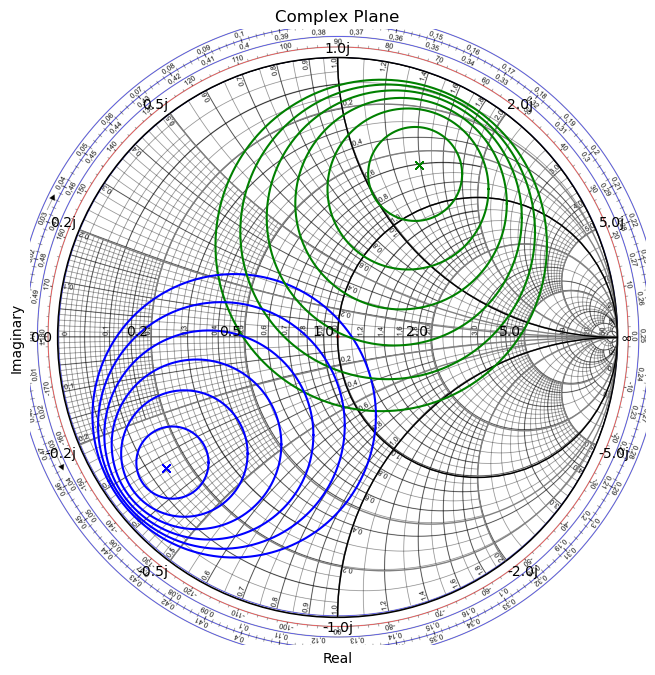

In [21]:
prep_fig_smith_chart()

gmax = val

#gain = 12

go = (1 - sqabs(rol))/(sqabs(1-s22*rol)-sqabs(s11-delta4GHz*rol))
cs = (np.conj(go*(s22-delta4GHz*np.conj(s11))))/(1+go*(sqabs(s22)-sqabs(delta4GHz)))
rs = (np.sqrt(1-2*k4Ghz*go*np.abs(s12*s21)+go**2*sqabs(s12*s21)))/(np.abs(1+go*(sqabs(s22)-sqabs(delta4GHz))))

#percorer varios valores de ganho
for gain in range(15, 27, 2):

    go = gain/sqabs(s21)
    cs = (np.conj(go*(s22-delta4GHz*np.conj(s11))))/(1+go*(sqabs(s22)-sqabs(delta4GHz)))
    rs = (np.sqrt(1-2*k4Ghz*go*np.abs(s12*s21)+go**2*sqabs(s12*s21)))/(np.abs(1+go*(sqabs(s22)-sqabs(delta4GHz))))


    ga = gain/sqabs(s21)
    cl = (ga*np.conj((s11-delta4GHz*np.conj(s22))))/(1+ga*(sqabs(s11)-sqabs(delta4GHz)))
    rl = (np.sqrt(1-2*k4Ghz*ga*np.abs(s12*s21)+ga**2*sqabs(s12*s21)))/(np.abs(1+ga*(sqabs(s11)-sqabs(delta4GHz))))

    sgc = calc_circle(cs, rs)
    sgl = calc_circle(cl, rl)
    skplt.plot_smith(s=np.squeeze(sgc), color = 'green', draw_labels=True)
    skplt.plot_smith(s=np.squeeze(sgl), color = 'blue', draw_labels=True)

#para ganho maximo raio =0
gain = gmax
go = gain/(sqabs(s21))
cs = (np.conj(go*(s22-delta4GHz*np.conj(s11))))/(1+go*(sqabs(s22)-sqabs(delta4GHz)))
rs = 0

ga = gain/(sqabs(s21))
cl = (ga*np.conj((s11-delta4GHz*np.conj(s22))))/(1+ga*(sqabs(s11)-sqabs(delta4GHz)))
rl = 0

sgc = calc_circle(cs, rs)
sgl = calc_circle(cl, rl)
skplt.plot_smith(s=np.squeeze(sgc), color = 'green', draw_labels=True, marker = 'x')
skplt.plot_smith(s=np.squeeze(sgl), color = 'blue', draw_labels=True, marker ='x')


#ss = rf.z2s(z=np.array([[[(zs.item())*50]]]), z0=50)
#sl = rf.z2s(z=np.array([[[(zl.item())*50]]]), z0=50)
#skplt.plot_smith(s=ss[0][0], smith_r=1, color = 'green', marker = 'x')
#skplt.plot_smith(s=sl[0][0], smith_r=1, color = 'blue', marker = 'x')


Equivalent Noise Resistance (Rn) at 4 GHz: [9.505]
Optimum Source Reflection Coefficient (Gamma_opt) at 4 GHz: [32.64188546-11.01826118j]
Minimum Noise Figure (NFmin) at 4 GHz: [2.171]
Optimum Source Admittance (Y_opt) at 4 GHz: [0.02750192+0.00928327j]
Optimum Source Reflection Coefficient (Ro_opt) at 4 GHz: [-0.18890656-0.15851142j]
[-0.02103606]


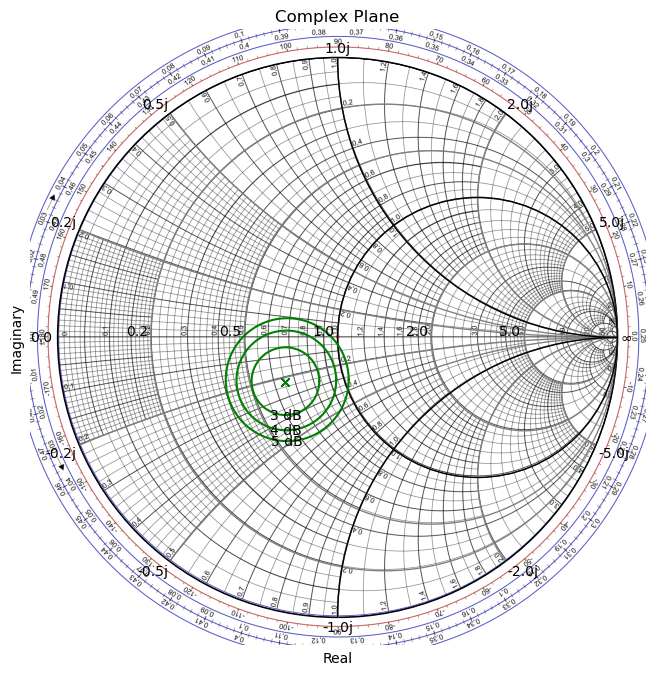

In [69]:
# Load the S-parameter file
noise = rf.Network('noise.s2p')

z0 = bjt.z0[0, 0]  # Assuming z0 is a scalar value
Fmin = noise.nfmin_db
rn = noise.rn
z_opt = noise.z_opt
y_opt = 1/z_opt

ro_opt = noise.g_opt
ys = 1/zs
gs = np.real(ys)
bs = np.imag(ys)

np.squeeze(rn)
np.squeeze(z_opt)
np.squeeze(Fmin)
np.squeeze(y_opt)
np.squeeze(ro_opt)

print("Equivalent Noise Resistance (Rn) at 4 GHz:", rn)
print("Optimum Source Reflection Coefficient (Gamma_opt) at 4 GHz:", z_opt)
print("Minimum Noise Figure (NFmin) at 4 GHz:", Fmin)
print("Optimum Source Admittance (Y_opt) at 4 GHz:", y_opt)
print("Optimum Source Reflection Coefficient (Ro_opt) at 4 GHz:", ro_opt)

#noise factor
F = Fmin + rn/gs * sqabs(ys*y_opt)

Fi= 1
#noise factor parameter
Ni = (Fi-Fmin)/(4*rn)*sqabs(1+ro_opt)
print(Ni)

prep_fig_smith_chart()
#percorer varios valores de ganho
for Fi in range(3, 6, 1):
    Ni = (Fi-Fmin)/(4*rn)*sqabs(1+ro_opt)
    #noise factor parameter
    cs = ro_opt/(1+Ni)
    rs = (1)/(1+Ni)*np.sqrt(Ni**2 + Ni*(1-sqabs(ro_opt)**2))

    sgc1 = calc_circle(cs, rs)
    skplt.plot_smith(s=np.squeeze(sgc1), color = 'green', draw_labels=True)

    plt.text(np.real(cs) , np.imag(cs) - rs, f"{Fi} dB",
             color='black', fontsize=10, ha='center', va='center')



Ni = 0
cs = ro_opt/(1+Ni)
rs = (1)/(1+Ni)*np.sqrt(Ni**2 + Ni*(1-sqabs(ro_opt)**2))

sgc = calc_circle(cs, rs)
skplt.plot_smith(s=np.squeeze(sgc), color = 'green', draw_labels=True, marker = 'x')






Ro das intersecções dos circulos ganho = 21 e ruido = 3dB
[-0.30695536-0.15142555j] [-0.22141437-0.27183862j]
Impedancias das intersecções dos circulos ganho = 21 e ruido = 3dB
[0.51000409-0.17495104j]
[0.56016594-0.34723135j]


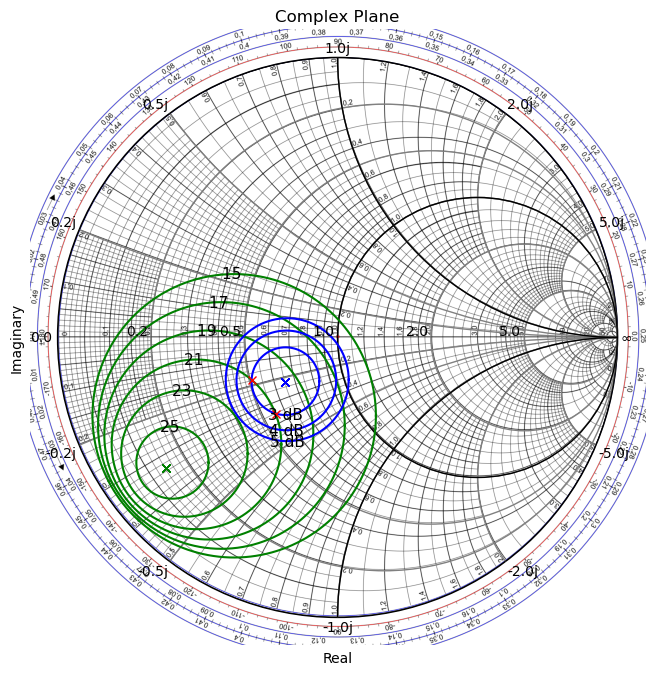

In [88]:
prep_fig_smith_chart()

def intersecao_circulos_complexos(c1, r1, c2, r2):
    """
    Calcula os pontos de intersecção entre dois círculos definidos por:
    - c1, c2: centros (números complexos)
    - r1, r2: raios (valores reais)
    
    Retorna dois pontos complexos ou None se não houver interseção.
    """
    d = abs(c2 - c1)

    # Verifica condições de existência da intersecção
    if d > r1 + r2 or d < abs(r1 - r2) or d == 0:
        return None  # Sem interseção válida

    # Distância do centro 1 até o ponto médio da intersecção
    a = (r1**2 - r2**2 + d**2) / (2 * d)
    h = np.sqrt(r1**2 - a**2)

    # Ponto médio ao longo da linha entre os centros
    p = c1 + a * (c2 - c1) / d

    # Vetor perpendicular (90 graus) no plano complexo
    offset = h * 1j * (c2 - c1) / d

    intersec1 = p + offset
    intersec2 = p - offset

    return intersec1, intersec2
#percorer varios valores de ganho
for gain in range(15, 27, 2):

    go = gain/sqabs(s21)
    cl = (np.conj(go*(s22-delta4GHz*np.conj(s11))))/(1+go*(sqabs(s22)-sqabs(delta4GHz)))
    rl = (np.sqrt(1-2*k4Ghz*go*np.abs(s12*s21)+go**2*sqabs(s12*s21)))/(np.abs(1+go*(sqabs(s22)-sqabs(delta4GHz))))


    ga = gain/sqabs(s21)
    cs = (ga*np.conj((s11-delta4GHz*np.conj(s22))))/(1+ga*(sqabs(s11)-sqabs(delta4GHz)))
    rs = (np.sqrt(1-2*k4Ghz*ga*np.abs(s12*s21)+ga**2*sqabs(s12*s21)))/(np.abs(1+ga*(sqabs(s11)-sqabs(delta4GHz))))

    sgc = calc_circle(cs, rs)
    sgl = calc_circle(cl, rl)
    skplt.plot_smith(s=np.squeeze(sgc), color = 'green', draw_labels=True)
    plt.text(np.real(cs) , np.imag(cs)  +rs, f"{gain} ",
             color='black', fontsize=11, ha='center', va='center')
    #skplt.plot_smith(s=np.squeeze(sgl), color = 'blue', draw_labels=True)

#para ganho maximo raio =0
gain = gmax
go = gain/(sqabs(s21))
cl = (np.conj(go*(s22-delta4GHz*np.conj(s11))))/(1+go*(sqabs(s22)-sqabs(delta4GHz)))
rl = 0

ga = gain/(sqabs(s21))
cs = (ga*np.conj((s11-delta4GHz*np.conj(s22))))/(1+ga*(sqabs(s11)-sqabs(delta4GHz)))
rs = 0

sgc = calc_circle(cs, rs)
sgl = calc_circle(cl, rl)
skplt.plot_smith(s=np.squeeze(sgc), color = 'green', draw_labels=True, marker = 'x')
#skplt.plot_smith(s=np.squeeze(sgl), color = 'blue', draw_labels=True, marker ='x')

#percorer varios valores de ganho
for Fi in np.arange(3, 6, 1):
    Ni = (Fi-Fmin)/(4*rn)*sqabs(1+ro_opt)

    #noise factor parameter
    cs = ro_opt/(1+Ni)
    rs = (1)/(1+Ni)*np.sqrt(Ni**2 + Ni*(1-sqabs(ro_opt)**2))

    sgc = calc_circle(cs, rs)
    skplt.plot_smith(s=np.squeeze(sgc), color = 'blue', draw_labels=True)
    plt.text(np.real(cs), np.imag(cs) - rs, f"{Fi} dB",
             color='black', fontsize=11, ha='center', va='center')


Ni = 0
cs = ro_opt/(1+Ni)
rs = (1)/(1+Ni)*np.sqrt(Ni**2 + Ni*(1-sqabs(ro_opt)**2))

sgc = calc_circle(cs, rs)
skplt.plot_smith(s=np.squeeze(sgc), color = 'blue', draw_labels=True, marker = 'x')

#interseções
Fi = 3
Ni = (Fi-Fmin)/(4*rn)*sqabs(1+ro_opt)

#noise factor parameter
csn = ro_opt/(1+Ni)
rsn = (1)/(1+Ni)*np.sqrt(Ni**2 + Ni*(1-sqabs(ro_opt)**2))


gain = 21
ga = gain/sqabs(s21)
cs = (ga*np.conj((s11-delta4GHz*np.conj(s22))))/(1+ga*(sqabs(s11)-sqabs(delta4GHz)))
rs = (np.sqrt(1-2*k4Ghz*ga*np.abs(s12*s21)+ga**2*sqabs(s12*s21)))/(np.abs(1+ga*(sqabs(s11)-sqabs(delta4GHz))))


pontos = intersecao_circulos_complexos(cs, rs, csn, rsn)
print("Ro das intersecções dos circulos ganho = 21 e ruido = 3dB")
print(pontos[0], pontos[1])


skplt.plot_smith(pontos[0], color = 'red', draw_labels=True, marker = 'x')
skplt.plot_smith(pontos[1], color = 'red', draw_labels=True, marker = 'x')

print("Impedancias das intersecções dos circulos ganho = 21 e ruido = 3dB")
zadap1 = (1+pontos[0])/(1-pontos[0])
print(zadap1)

zadap2 = (1+pontos[1])/(1-pontos[1])
print(zadap2)

### Results MAX gain


Frequency point at 4 GHz:
2-Port Network: 'Sparam-LCmatched_subset',  3990249023.61949-3990249023.61949 Hz, 1 pts, z0=[50.+0.j 50.+0.j]


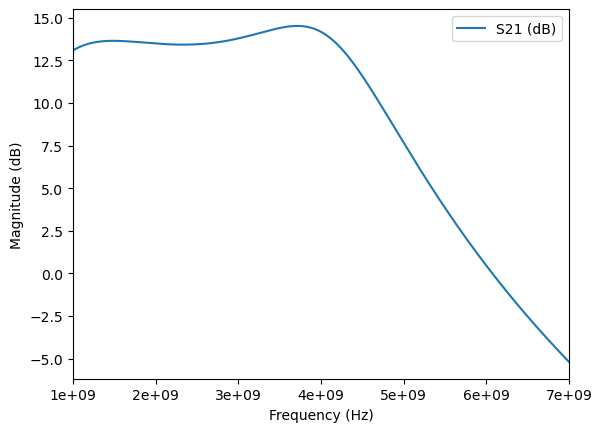

In [25]:
# Results for the LC matching circuit

LNA_LC = rf.Network('Sparam-LCmatched.s2p', )

# Load the S-parameter file
s = LNA_LC.s.copy()
s[:,0,1], s[:,1,0] = s[:,1,0].copy(), s[:,0,1].copy()
LNA_LC.s = s

# Filter for 4 GHz
freq_idx = np.where(np.isclose(LNA_LC.f, 4e9, atol=1e7))[0][0]
freq_point = LNA_LC[freq_idx]
print(f"Frequency point at 4 GHz:\n{freq_point}")

LNA_LC.s21.plot_s_db(label='S21 (dB)')

freq = '3990249023.61949'

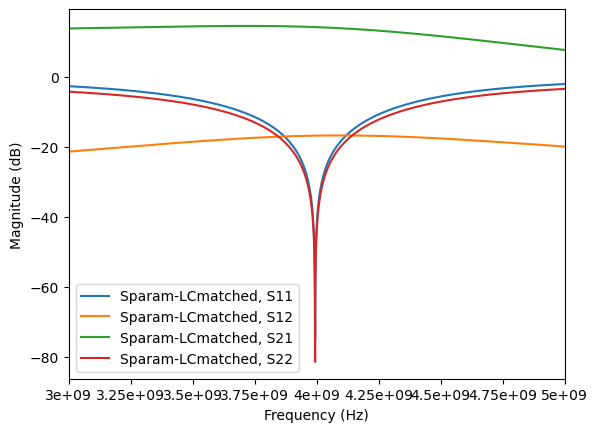

In [26]:
# plot matched S-parameters in dB
LNA_LC['3-5ghz'].plot_s_db()

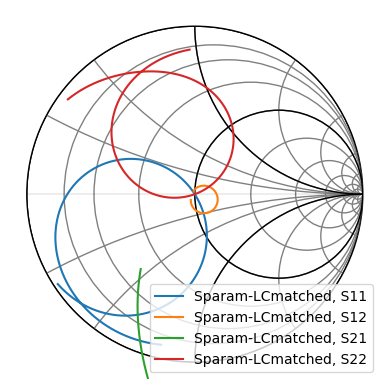

In [27]:
# plot the S-parameters in dB in the smith chart
LNA_LC.plot_s_smith()

In [29]:
LNA_LC[freq].max_stable_gain

array([35.65435245])

In [30]:
LNA_LC[freq].max_gain

array([26.32063151])

In [31]:
LNA_LC[freq].stability #k factor

array([1.04641633])

In [32]:
# Calculate the noise figure
# 10*np.log10(LNA_LC.nf(50.)[freq_idx])

Frequency point at 4 GHz:
2-Port Network: 'Sparam-LSmatched_subset',  3990249023.61949-3990249023.61949 Hz, 1 pts, z0=[50.+0.j 50.+0.j]


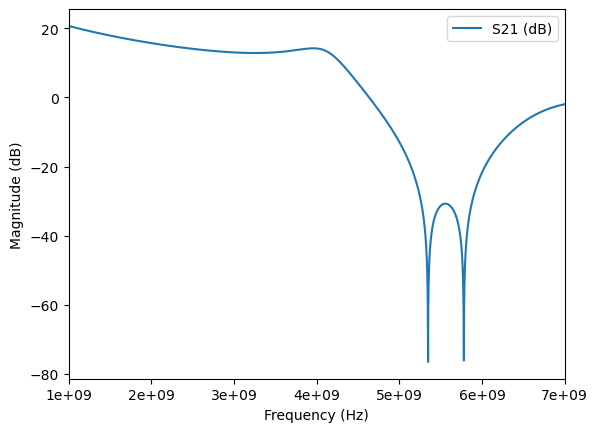

In [33]:
# Results for the LS matching circuit

LNA_LS = rf.Network('Sparam-LSmatched.s2p', )

# Load the S-parameter file
s = LNA_LS.s.copy()
s[:,0,1], s[:,1,0] = s[:,1,0].copy(), s[:,0,1].copy()
LNA_LS.s = s

# Filter for 4 GHz
freq_idx = np.where(np.isclose(LNA_LS.f, 4e9, atol=1e7))[0][0]
freq_point = LNA_LS[freq_idx]
print(f"Frequency point at 4 GHz:\n{freq_point}")

LNA_LS.s21.plot_s_db(label='S21 (dB)')

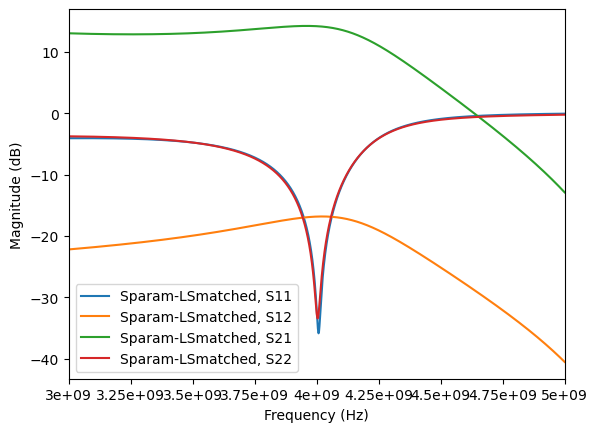

In [34]:
# plot the S-parameters in dB
LNA_LS['3-5ghz'].plot_s_db()

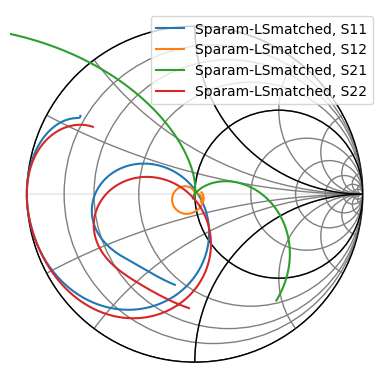

In [35]:
# Plot the S-parameters in the smith chart
LNA_LS.plot_s_smith()

### Noise

ros: (-0.1889065597-0.1585114245j)
zs: (0.6528377091379025-0.22036522349483478j)
rol: [0.12253564+0.27694468j]
zl: [1.07281071+0.65421904j]
rs: 0.6528377091379025
xs: -0.22036522349483478
rl: [1.07281071]
xl: [0.65421904]


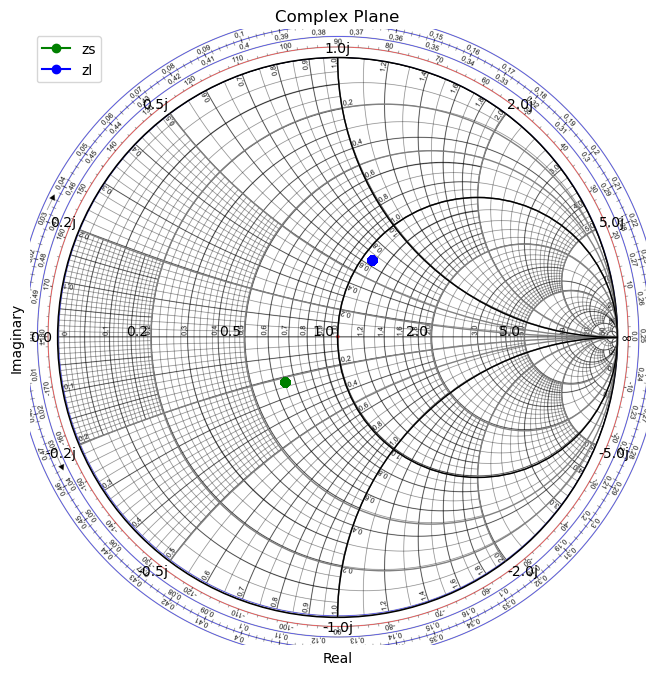

In [39]:
ros = -0.1889065597-0.1585114245j
print('ros:', ros)
zsn = (1 + ros) / (1 - ros)
print('zs:', zsn)
rol = np.conj(s22+(s12*s21*ros)/(1-s11*ros))
print('rol:', rol)
zln = (1 + rol) / (1 - rol)
print('zl:', zln)
rsn = np.real(zsn)
print('rs:', rsn)
xsn = np.imag(zsn)
print('xs:', xsn)
rln = np.real(zln)
print('rl:', rln)
xln = np.imag(zln)
print('xl:', xln)


prep_fig_smith_chart()

zspoint = calc_point_in_smith_circle(zsn)
zlpoint = calc_point_in_smith_circle(zln)
skplt.plot_smith(s=(zspoint), color = 'green', draw_labels=True, marker = 'o', label='zs')
skplt.plot_smith(s=(zlpoint), color = 'blue', draw_labels=True, marker ='o', label='zl')



In [37]:
print(z0)
print(f)
print(rs)
print(xs)
print("------------------------------------")
print("Calc source matching circuit")
calc_lumped_matching_circuits(f, 1, rsn, xsn)
print("------------------------------------")
print("Calc load matching circuit")
calc_lumped_matching_circuits(f, 1, rln, xln)

(50+0j)
4003110721.81212
[0.]
-0.3298276906439486
------------------------------------
Calc source matching circuit
------------------------------------
Z0 - Bparalelo + Xserie - Z
X+ =  0.2557026652200815
X- =  -0.6964331122097511
B+ =  0.7292285388103306
B- =  -0.7292285388103306
------------------------------------
L_serie =  5.083089871809204e-10
C_paralelo =  5.798506944259898e-13
L_paralelo =  2.7260189899300953e-09
C_serie =  1.141755502399045e-12
------------------------------------
------------------------------------
Calc load matching circuit
------------------------------------
Z0 - Xserie + Bparalelo - Z
B+ =  [0.05234111]
X+ =  [0.68685159]
B- =  [-0.8810301]
X- =  [-0.68685159]
------------------------------------
L_serie =  [1.36538599e-09]
C_paralelo =  [4.16193643e-14]
L_paralelo =  [2.25632568e-09]
C_serie =  [1.15768289e-12]
------------------------------------


In [44]:
print("------------------------------------")
print("Calc source matching circuit")
calc_lines_stubs_circuit(50,zsn,f)
print("\n------------------------------------")
print("Calc loud matching circuit")
calc_lines_stubs_circuit(50,zln,f)

------------------------------------
Calc source matching circuit
------------------------------------
Calc shunt stubs
------------------------------------
t1: -1.5917778162499951
t2: 0.3222550063410703
B1: 0.010178333913239059
d1_lt: -1.2338962918610167e-12
d1_cadence: -0.21190907825799235
B2: -0.010178333913239062
d2_lt: 1.2394385963389397e-11
d2_cadence: 2.128609124122016
>>>>>>> Open circuit
l1_tl: 1.0618665475531378e-10
l1_can: -3.2143179211614417
l2_tl: 1.8716210727672656e-11
l2_can: 3.2143179211614425
>>>>>>> Short circuit
l1_tl: 4.373522201382058e-11
l1_can: 7.511077426433678
l2_tl: 8.116764346916586e-11
l2_can: -7.511077426433677

------------------------------------
Calc loud matching circuit
------------------------------------
Calc shunt stubs
------------------------------------
t1: [0.37882255]
t2: [-18.34922924]
B1: [0.01271056]
d1_lt: [1.43970103e-11]
d1_cadence: [2.47253939]
B2: [-0.01271056]
d2_lt: [-6.44938423e-11]
d2_cadence: [-11.07615832]
>>>>>>> Open circuit
l1_